# Imports

In [2]:
import os
import csv
import numpy as np
import pprint

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

import pandas as pd

from timeit import default_timer as timer
import joblib

import tensorflow as tf
import tensorflowjs as tfjs

from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Generic Class for multiclass objects detection

In [36]:
class ObjectDetectionGenerator:
    def __init__(self, X_train, y_train, X_test, y_test, dir_path=None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.y_train_aabb = None
        self.y_val_aabb = None
        self.y_test_aabb = None
        self.dir_path = dir_path
        
    @staticmethod
    def list_first_val(arr):
        for i in arr:
            if i > 0:
                return 1
        return -1
    
    @staticmethod
    def get_aabb2D(data):
        """aligned-axis bounding-box (bounding square)"""
        x1 = 0xffff
        y1 = 0xffff
        x2 = 0
        y2 = 0
        # y1
        for j in range(len(data)):
            if list_first_val(data[j]) > 0:
                y1 = j
                break
        # y2
        for j in range(len(data)):
            end = len(data)-j-1
            if list_first_val(data[end]) > 0:
                y2 = end
                break
        # x1, x2
        for j in range(len(data)):
            ydata = data[j]
            val = 0xffff
            last = 0
            for i in range(len(ydata)):
                if ydata[i] > 0:
                    x1 = min(x1,i)
                    x2 = max(x2,i)
        return np.array([x1,y1, x2+1,y2+1])

    @staticmethod
    def get_X_aabb2D(X):
        aabbs = []
        for i in range(len(X)):
            aabbs.append(get_aabb2D(X[i]))
            #if i > 10: break
        return aabbs
    
    @staticmethod
    def read_aabb_csv(dir_path, filename):
        file_path = os.path.join(dir_path, filename)
        df = pd.read_csv(file_path)
        return np.array(list(df.itertuples(index=False, name=None)))

    @staticmethod
    def write_aabb_csv(dir_path, filename, X):
        file_path = os.path.join(dir_path, filename)
        aabb = get_X_aabb2D(X)
        df = pd.DataFrame(aabb, columns=['x1','y1','x2','y2'])
        df.to_csv(file_path, index=False)
        return aabb
    
    @staticmethod
    def scaling(train, val, test, div=1):
        train_scaled = train / div
        val_scaled = val / div
        test_scaled = test / div
        return train_scaled, val_scaled, test_scaled

    @staticmethod
    def list_first_val(arr):
        for i in arr:
            if i > 0:
                return 1
        return -1
    
    @staticmethod
    def get_aabb2D(data):
        """aligned-axis bounding-box (bounding square)"""
        x1 = 0xffff
        y1 = 0xffff
        x2 = 0
        y2 = 0
        # y1
        for j in range(len(data)):
            if list_first_val(data[j]) > 0:
                y1 = j
                break
        # y2
        for j in range(len(data)):
            end = len(data)-j-1
            if list_first_val(data[end]) > 0:
                y2 = end
                break
        # x1, x2
        for j in range(len(data)):
            ydata = data[j]
            val = 0xffff
            last = 0
            for i in range(len(ydata)):
                if ydata[i] > 0:
                    x1 = min(x1,i)
                    x2 = max(x2,i)
        return np.array([x1,y1, x2+1,y2+1])

    @staticmethod
    def get_X_aabb2D(X):
        aabbs = []
        for i in range(len(X)):
            aabbs.append(get_aabb2D(X[i]))
            #if i > 10: break
        return aabbs
    
    @staticmethod
    def read_aabb_csv(dir_path, filename):
        file_path = os.path.join(dir_path, filename)
        df = pd.read_csv(file_path)
        return np.array(list(df.itertuples(index=False, name=None)))

    @staticmethod
    def write_aabb_csv(dir_path, filename, X):
        file_path = os.path.join(dir_path, filename)
        aabb = get_X_aabb2D(X)
        df = pd.DataFrame(aabb, columns=['x1','y1','x2','y2'])
        df.to_csv(file_path, index=False)
        return aabb

    @staticmethod
    def scaling2D(X_train, X_val, X_test, div=[1,1]):
        mat2_div = np.array([div[0],div[1],div[0],div[1]])
        X_train_scaled = X_train / mat2_div
        X_val_scaled = X_val / mat2_div
        X_test_scaled = X_test / mat2_div
        return X_train_scaled, X_val_scaled, X_test_scaled

    
    def gen_aabb(self, gen_files=True, test_size=0.25, random_state=1):
        if (not gen_files) or self.dir_path == None:
            self.y_train_aabb = get_X_aabb2D(self.X_train)
            self.y_test_aabb = get_X_aabb2D(self.X_test)
            return
        # folder exists ?
        if not os.path.exists(self.dir_path):
            os.mkdir(self.dir_path)
        # load aabb
        if os.path.exists(os.path.join(self.dir_path, 'aabb_train.csv')):
            self.y_train_aabb = read_aabb_csv(self.dir_path, 'aabb_train.csv')
            self.y_test_aabb = read_aabb_csv(self.dir_path, 'aabb_test.csv')
            print("bounding-squares csv loaded")
        else: # or compute them (slow!)
            self.y_train_aabb = write_aabb_csv(self.dir_path, 'aabb_train.csv', self.X_train)
            self.y_test_aabb = write_aabb_csv(self.dir_path, 'aabb_test.csv', self.X_test)
            print("bounging-squares csv computed")
        
        self.y_train_aabb, self.y_val_aabb = train_test_split(self.y_train_aabb,
                                                              test_size=test_size,
                                                              random_state=random_state)
    
    def transform_scale(self, scale=[1,1]):
        self.y_train_aabb, self.y_val_aabb, self.y_test_aabb = self.scaling2D(self.y_train_aabb,
                                                                              self.y_val_aabb,
                                                                              self.y_test_aabb, scale)
    def gen_multiclass_images(self, width,height):
        self.test = np.zeros((300, 300, 1))
        pass
        
# test
#(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path="mnist.npz")
#og = ObjectDetectionGenerator(X_train, y_train, X_test, y_test,
#                              os.path.join(os.path.dirname(os.getcwd()), 'dataset'))
#og.gen_aabb()
#og.transform_scale([28.,28.])

# Dataset

In [41]:

def get_data(random_state=1):
    (X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path="mnist.npz")
    
    # data augmentation + BoundingBoxes
    og = ObjectDetectionGenerator(X_train, y_train, X_test, y_test,
                                  os.path.join(os.path.dirname(os.getcwd()), 'dataset'))
    og.gen_aabb(random_state=random_state)
    og.transform_scale([28.,28.])
    
    # add a dim: (28, 28) -> (28, 28, 1)
    X_train = X_train.reshape(len(X_train), 28,28,1) # np.expand_dims(X_train, axis=-1)
    X_test = X_test.reshape(len(X_test), 28,28,1)
    
    # to categorical
    y_train_cat = to_categorical(y_train, num_classes=10, dtype ="uint8")
    y_test_cat = to_categorical(y_test, num_classes=10, dtype ="uint8")
    
    # split train/validation
    X_train, X_val, y_train_cat, y_val_cat = train_test_split(X_train, y_train_cat,
                                                              test_size=0.25,
                                                              random_state=random_state)
    # scaling
    X_train_scaled, X_val_scaled, X_test_scaled = scaling(X_train,X_val,X_test, 255.)
    
    return (X_train, y_train),(X_train_scaled, y_train_cat),(X_val_scaled, y_val_cat),(X_test_scaled, y_test_cat),(og.y_train_aabb, og.y_val_aabb, og.y_test_aabb)

            
(X_train, y_train),(X_train_scaled, y_train_cat),(X_val_scaled, y_val_cat),(X_test_scaled, y_test_cat),(y_train_aabb, y_val_aabb, y_test_aabb) = get_data()

#print("train/valid:", X_train.shape, y_train.shape)
#print("test:", X_test.shape, y_test.shape)
print("")
print("X_train:", X_train_scaled.shape);
print("X_val:", X_val_scaled.shape);
print("X_test:", X_test_scaled.shape);
print("")
print("y_train_cat:", y_train_cat.shape);
print("y_val_cat:", y_val_cat.shape);
print("y_test_cat:", y_test_cat.shape);
print("")
print("y_train_aabb:", y_train_aabb.shape);
print("y_val_aabb:", y_val_aabb.shape);
print("y_test_aabb:", y_test_aabb.shape);


bounding-squares csv loaded

X_train: (45000, 28, 28, 1)
X_val: (15000, 28, 28, 1)
X_test: (10000, 28, 28, 1)

y_train_cat: (45000, 10)
y_val_cat: (15000, 10)
y_test_cat: (10000, 10)

y_train_aabb: (45000, 4)
y_val_aabb: (15000, 4)
y_test_aabb: (10000, 4)

X_train: (28, 28, 1)
(28, 28, 1)


In [34]:
list(X_train[0][14])

[array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([63], dtype=uint8),
 array([245], dtype=uint8),
 array([241], dtype=uint8),
 array([38], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8)]

# Draw image + Bounding Box

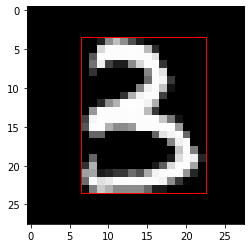

In [56]:
def plt_rectangle(tup):
    x1 = tup[0]
    y1 = tup[1]
    x2 = tup[2]
    y2 = tup[3]
    plt.gca().add_patch(Rectangle((x1-0.5,y1-0.5),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none'))
    return


idx = 18
plt.imshow(X_train_scaled[idx], cmap='gray');
plt_rectangle(y_train_aabb[idx] * 28)


label is: Number 5


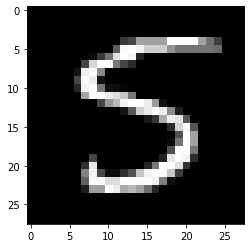

In [10]:
labels = ["Number 0",
          "Number 1",
          "Number 2",
          "Number 3",
          "Number 4",
          "Number 5",
          "Number 6",
          "Number 7",
          "Number 8",
          "Number 9"]

def categorical_to_id(arr_cat, labels=None):
    res = -1
    for i in range(len(arr_cat)):
        if arr_cat[i]:
            res = i
            break
    if labels is None:
        return res
    return labels[res]

item = 21

print("label is:", categorical_to_id(y_train_cat[item], labels))
plt.imshow(X_train_scaled[item], cmap='gray');

# Model with mixed data (functional API)
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

In [ ]:

def get_classification_model(X):
    """ classification with 10 classes """
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', input_shape=X[0].shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(2,2), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='softmax'))
    return model

def get_regression_model(X):
    """ regression with 4 outputs """
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, (4,4), activation='relu', padding='same', input_shape=X[0].shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
        
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(4, activation='linear'))
    return model

In [24]:
def get_model(X):
    """ classification + regression with 10+4 outputs """
    # define two sets of inputs
    inputs = layers.Input(shape=X[0].shape)

    # the first branch operates on the first input
    a = layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    a = layers.MaxPool2D(pool_size=(2,2))(a)
    
    a = layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(a)
    a = layers.MaxPool2D(pool_size=(2,2))(a)
    a = layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(a)
    #a = layers.MaxPool2D(pool_size=(2,2))(a)
    a = layers.Flatten()(a)
    a = layers.Dense(64, activation='relu')(a)
    
    # output for classification
    out_softmax = layers.Dense(10, activation='softmax', name='out_softmax')(a)
    
    # output for regression
    out_bbox = layers.Dense(32, activation="relu")(a)
    out_bbox = layers.Dense(4, activation='sigmoid', name='out_bbox')(a)
    
    model = models.Model(inputs=inputs, outputs=[out_softmax,out_bbox])
    return model

#model = get_classification_model(X_train_scaled)
#model = get_regression_model(X_train_scaled)
model = get_model(X_train_scaled)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['max_pooling2d[0][0]']          


2023-04-27 09:44:17.818539: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-27 09:44:17.818614: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-27 09:44:17.818646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-DIV5ILM): /proc/driver/nvidia/version does not exist
2023-04-27 09:44:17.819038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 7, 7, 64)    0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 7, 64)     36928       ['max_pooling2d_1[0][0]']        
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_2[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 64)           200768      ['flatten[0][0]']                
                                                                                                  
 out_softmax (Dense)            (None, 10)           650         ['dense[0][0]']                  
          

# Train 

In [61]:

def run(model, X_train,y_train, X_val,y_val,
        opt = 'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        epochs = 50,
        batch_size = 16):
    
    # https://distill.pub/2017/momentum/
    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
    model.compile(optimizer=opt, 
                  loss=loss,
                  metrics=metrics)
    
    # early stopping
    es = EarlyStopping(patience = 10, restore_best_weights = True)
    
    start_time = timer()
    history = model.fit(X_train, 
                        y_train,
                        #validation_split = 0.3, # auto val generation
                        validation_data = (X_val, y_val),
                        batch_size = batch_size,
                        epochs = epochs,
                        callbacks = [es],
                        verbose = 1)
    
    training_time = timer() - start_time
    print("training time:", training_time)
    
    return history

# classification with N classes
#history = run(model, X_train_scaled,y_train_cat, X_val_scaled,y_val_cat)

# regression
"""history = run(model, X_train_scaled,aabb_train, X_val_scaled,aabb_val,
              loss='mse',
              metrics=['mae'],
              opt=optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999))"""

# classification + regression
history = run(model, X_train_scaled,[y_train_cat,y_train_aabb], X_val_scaled,[y_val_cat,y_val_aabb],
              loss={'out_softmax': 'categorical_crossentropy',
                    'out_bbox': 'mse'},
              metrics={'out_softmax': 'accuracy',
                       'out_bbox': 'mae'},
              opt=optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))

# print("aabb_train:", aabb_train[0]);
# print("aabb_val:", aabb_val[0]);
# print("aabb_test:", aabb_test[0]);

Epoch 1/50
2813/2813 [==============================] - 47s 16ms/step - loss: 0.1828 - out_softmax_loss: 0.1754 - out_bbox_loss: 0.0074 - out_softmax_accuracy: 0.9451 - out_bbox_mae: 0.0625 - val_loss: 0.0911 - val_out_softmax_loss: 0.0889 - val_out_bbox_loss: 0.0022 - val_out_softmax_accuracy: 0.9714 - val_out_bbox_mae: 0.0363
Epoch 2/50
2813/2813 [==============================] - 42s 15ms/step - loss: 0.0600 - out_softmax_loss: 0.0583 - out_bbox_loss: 0.0016 - out_softmax_accuracy: 0.9815 - out_bbox_mae: 0.0309 - val_loss: 0.0619 - val_out_softmax_loss: 0.0607 - val_out_bbox_loss: 0.0012 - val_out_softmax_accuracy: 0.9818 - val_out_bbox_mae: 0.0263
Epoch 3/50
2813/2813 [==============================] - 42s 15ms/step - loss: 0.0424 - out_softmax_loss: 0.0413 - out_bbox_loss: 0.0011 - out_softmax_accuracy: 0.9865 - out_bbox_mae: 0.0255 - val_loss: 0.0620 - val_out_softmax_loss: 0.0610 - val_out_bbox_loss: 0.0010 - val_out_softmax_accuracy: 0.9836 - val_out_bbox_mae: 0.0245
Epoch 4/50

# Layers & Filters

In [67]:
layer_1 = model.layers[0]
layer_1.weights[0].shape

TensorShape([3, 3, 1, 16])

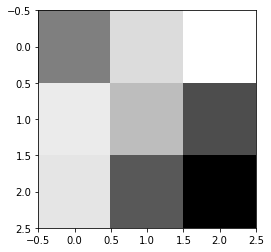

In [68]:
plt.imshow(layer_1.weights[0][:,:,:,15], cmap='gray');

In [69]:
batch = X_train_scaled[0:10]
activation_1 = layer_1(batch)
activation_1.shape

TensorShape([10, 28, 28, 16])

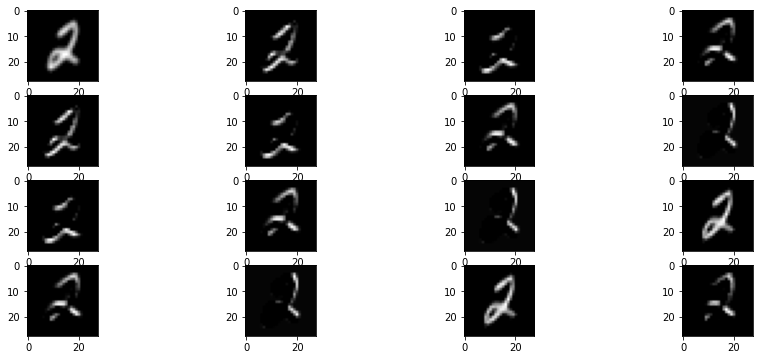

In [70]:
# first channel output on the first image
fit, axs = plt.subplots(4,4, figsize=(15,6))
for i in range(4):
    for j in range(4):
        feature_map = activation_1[0,:,:,i+j]
        axs[i,j].imshow(feature_map, cmap='gray')

# Plot results

In [62]:
def plot_history(history, labels = ["loss"]):
    h = history.history
    with plt.style.context('seaborn-deep'):
        fig, ax = plt.subplots(1, max(2,len(labels)), figsize=(15, 4))
        x_axis = np.arange(len(h[labels[0]]))
        for i in range(len(labels)):
            l = labels[i]
            L = l.capitalize()
            ax[i].set_title(l)
            ax[i].plot(x_axis, h[l], color="blue", linestyle=":", marker="X", label="Train "+L)
            ax[i].plot(x_axis, h['val_'+l], color="orange", linestyle="-", marker="X", label="Val "+L)
            ax[i].grid(axis="x", linewidth=0.5)
            ax[i].grid(axis="y", linewidth=0.5)
            ax[i].legend()
        plt.show()

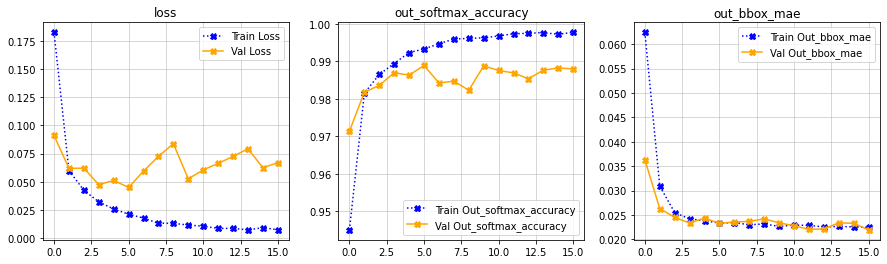

In [63]:
#plot_history(history, ["loss", "accuracy"])
plot_history(history, ["loss", "out_softmax_accuracy", "out_bbox_mae"])

# Baseline Score

Zero Rate Classifier:
- https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f

In [12]:
distr = pd.Series(y_train).value_counts()
distr

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

In [55]:
def categorical_baseline(y_train):
    distr = pd.Series(y_train).value_counts()
    total = len(y_train)
    return ((distr / total) ** 2).sum()

baseline = categorical_baseline(y_train)

print("Our baseline is: " + str(baseline*100) + "%")

Our baseline is: 10.028815944444444%


# Evaluation vs test set

In [64]:
def evaluate(X_train,y_train, X_val,y_val, X_test, y_test):
    eval_res = {
        "train": model.evaluate(X_train, y_train, batch_size=None, verbose = 1)[1],
        "val": model.evaluate(X_val, y_val, batch_size=None, verbose = 1)[1],
        "test": model.evaluate(X_test, y_test, batch_size=None, verbose = 1)[1]
    }
    return eval_res

#eval_res = evaluate(X_train_scaled,y_train_cat, X_val_scaled,y_val_cat, X_test_scaled, y_test_cat)
#eval_res = evaluate(X_train_scaled,y_train_aabb, X_val_scaled,y_val_aabb, X_test_scaled, y_test_aabb)

eval_res = evaluate(X_train_scaled, [y_train_cat,y_train_aabb],
                    X_val_scaled, [y_val_cat,y_val_aabb],
                    X_test_scaled, [y_test_cat,y_test_aabb])

#print(f'The accuracy on the train set is of {eval_res["train"]*100:.2f} %')
#print(f'The accuracy on the val set is of {eval_res["val"]*100:.2f} %')
#print(f'The accuracy on the test set is of {eval_res["test"]*100:.2f} %')

313/313 [==============================] - 3s 9ms/step - loss: 0.0353 - out_softmax_loss: 0.0344 - out_bbox_loss: 9.2117e-04 - out_softmax_accuracy: 0.9887 - out_bbox_mae: 0.0231


In [47]:
model.predict(X_test_scaled)
#model.predict(np.array([X_test_scaled[label]]))[0]

1/1 [==============================] - 0s 31ms/step


array([[1.5612330e-05, 4.5116025e-10, 6.6141633e-06, 1.0511721e-09,
        1.7484422e-04, 7.8093956e-07, 9.9978155e-01, 1.4887961e-14,
        2.0626305e-05, 8.8840124e-10]], dtype=float32)

# Predict one observation

1/1 [==============================] - 0s 40ms/step
Prediction is = Number 7 (100.00%)


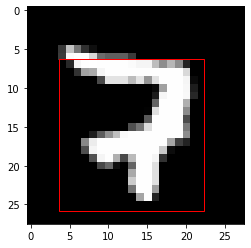

In [69]:
label = 133

predicted = model.predict(np.array([X_test_scaled[label]]))
predicted_class = list(predicted[0][0])
predicted_linear = predicted[1][0]

#print("prediction table:", predicted)
plt.imshow(X_test_scaled[label], cmap='gray')

predicted_label = labels[predicted_class.index(max(predicted_class))]
print("Prediction is =", predicted_label, f"({max(predicted_class)*100:.2f}%)")

plt_rectangle(predicted_linear*28)
plt.show()

# Class Scores

In [76]:
print(f"Prediction table for '{predicted_label}':")
print("\n",predicted)

Prediction table for 'Number 9':

 [3.3507745e-19, 4.752253e-17, 4.743725e-16, 7.314405e-13, 5.44116e-07, 2.1716316e-13, 6.824018e-21, 6.388595e-08, 4.7820276e-11, 0.9999994]


# Save

In [70]:
def create_csv_id():
    dir_path = os.path.join(os.path.dirname(os.getcwd()), 'models')
    file_path = os.path.join(dir_path, 'ids.csv')
    cur_id = 0
    # folder exists ?
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    # file exists ?
    if not os.path.exists(file_path):
        df = pd.DataFrame([0], columns=['id'])
        df.to_csv(file_path, index=False)
    else:
        # csv -> dataframe
        df = pd.read_csv(file_path)
        cur_id = df["id"].iloc[-1] + 1
        with open(file_path, "a") as f:
            csv.writer(f).writerow([cur_id])
            
    return {"cur_id": cur_id, "dir_path": dir_path}


def save_model(model):
    res = create_csv_id()
    dir_path = res["dir_path"]
    str_id = str(res["cur_id"]).zfill(4)
    base_name = f'model_{str_id}'
    
    # normal
    joblib.dump(model, os.path.join(dir_path, base_name+'.pkl'))
    
    # for tensorflow.js
    tfjs.converters.save_keras_model(model, os.path.join(dir_path, base_name))

    # for lite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(os.path.join(dir_path, base_name+'.tflite'), 'wb') as f:
        f.write(tflite_model)
    return

save_model(model)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......flatten
.........vars
......input_layer
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_1
.........vars
............0
............1
......mean_2
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......mean_metric_wrapper_1
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
....

/home/nes/.pyenv/versions/3.8.12/envs/BatteryProject/lib/python3.8/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


INFO:tensorflow:Assets written to: /tmp/tmpi0y8eh99/assets


INFO:tensorflow:Assets written to: /tmp/tmpi0y8eh99/assets
2023-04-27 00:16:30.553779: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-27 00:16:30.553865: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-27 00:16:30.554723: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi0y8eh99
2023-04-27 00:16:30.557388: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-27 00:16:30.557418: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi0y8eh99
2023-04-27 00:16:30.564968: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-04-27 00:16:30.737197: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


# Links

https://github.com/weiliu89/caffe/tree/ssd